# Fine-tuning SmolVLM using direct preference optimization (DPO) with TRL on a consumer GPU

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_


In this recipe, we’ll guide you through fine-tuning a **smol 🤏 Vision Language Model (VLM)** using the Hugging Face ecosystem with **Direct Preference Optimization (DPO)**. We’ll leverage the powerful **Transformer Reinforcement Learning (TRL)** library to demonstrate how you can tailor VLMs to suit your specific needs, even when working with consumer-grade GPUs.

We’ll fine-tune **SmolVLM** using a **preference dataset** to help the model align with desired outputs. If you’re new to **Preference Optimization** for language or vision-language models, check out [this blog](https://huggingface.co/blog/dpo_vlm) for an in-depth introduction.

The dataset we’ll use is [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted), which contains pairs of **`prompt + image`** along with a **`chosen`** and **`rejected`** answer for each pair. The goal of this fine-tuning process is to make the model consistently prefer the **chosen answers** from the dataset, reducing hallucinations.

---

## 📖 Additional Resources

Expand your knowledge of Vision Language Models and related tools with these resources:

- **[Multimodal Recipes in the Cookbook](https://huggingface.co/learn/cookbook/index):** Discover practical recipes for multimodal models, including Retrieval-Augmented Generation (RAG) pipelines and fine-tuning. We’ve already published [a recipe for fine-tuning a smol VLM with TRL using SFT](https://huggingface.co/learn/cookbook/fine_tuning_smol_vlm_sft_trl), which complements this guide perfectly—check it out for additional details.
  
- **[TRL Community Tutorials](https://huggingface.co/docs/trl/main/en/community_tutorials):** Explore a rich collection of tutorials that dive into the intricacies of TRL and its real-world applications.

By combining this guide with the resources above, you’ll be well-equipped to customize Vision Language Models and unlock their full potential. Let’s push the boundaries of what these models can achieve together!

---

This notebook has been tested using an **NVIDIA L4 GPU**.



![Smol VLMs comparison](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/smolvlm_ecosystem.png)

# 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀

In [1]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.46.3, trl==0.12.2, datasets==3.2.0, bitsandbytes==0.45.0, peft==0.14.0, accelerate==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

In [2]:
!pip install -q flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Dataset 📁

We’ll work with the [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted) dataset, which provides pairs of **`prompt + image`** along with a **`chosen`** and **`rejected`** answers for each pair. This structured format is ideal for training models with **Direct Preference Optimization (DPO)**.

The dataset is already preformatted for this task. If you’re working with a custom dataset, you’ll need to preprocess it into the same format.

In this example, we’ll use a subset of the dataset to streamline the process. However, in a real-world scenario, you might utilize the full dataset for comprehensive fine-tuning.


In [4]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:6%]', 'test[:1%]'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

train-00000-of-00013.parquet:   0%|          | 0.00/569M [00:00<?, ?B/s]

train-00001-of-00013.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00002-of-00013.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00003-of-00013.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

train-00004-of-00013.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

train-00005-of-00013.parquet:   0%|          | 0.00/531M [00:00<?, ?B/s]

train-00006-of-00013.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00007-of-00013.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00008-of-00013.parquet:   0%|          | 0.00/526M [00:00<?, ?B/s]

train-00009-of-00013.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

train-00010-of-00013.parquet:   0%|          | 0.00/518M [00:00<?, ?B/s]

train-00011-of-00013.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00012-of-00013.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78975 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4157 [00:00<?, ? examples/s]

We will ensure all the images are RGB formatted:

In [5]:
from PIL import Image

def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example['images'][0]
    if isinstance(image, Image.Image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        example['images'] = [image]
    return example

# Apply the transformation to the dataset
train_dataset = train_dataset.map(ensure_rgb, num_proc=32)
test_dataset = test_dataset.map(ensure_rgb, num_proc=32)

Map (num_proc=32):   0%|          | 0/4738 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/42 [00:00<?, ? examples/s]

Let’s explore an example from the dataset to better understand its structure and the type of data we’re working with.


In [6]:
train_dataset[20]

{'chosen': [{'content': [{'text': "Yes, the grass in the image appears to be brown. This could indicate that the photo was taken during a dry season or in a region that experiences arid conditions. The brown grass contrasts with the grayish color of the elephant and provides a natural background that highlights the elephant's presence in its environment.",
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'Yes, the grass in the image appears to be brown. This could be due to a number of reasons such as the season (it might be a dry season), the type of grass, or the specific conditions of the environment where the photo was taken. The brown grass contrasts with the grayish color of the elephant and the white branches of the thorny tree, making it a prominent feature of the landscape.',
     'type': 'text'}],
   'role': 'assistant'}],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>],
 'prompt': [{'content': [{'text': None, '

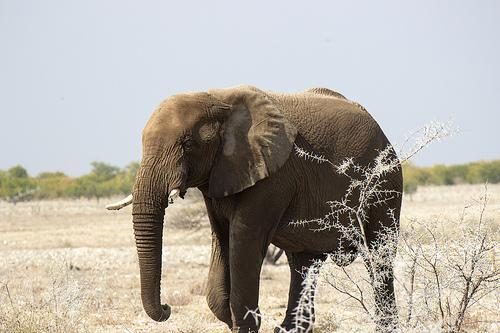

In [7]:
train_dataset[20]['images'][0]

# 3. Fine-Tune the Model using TRL



## 3.1 Load the Quantized Model for Training ⚙️


Let's first load the model and processor, along with the quantized configuration using BitsAndBytes

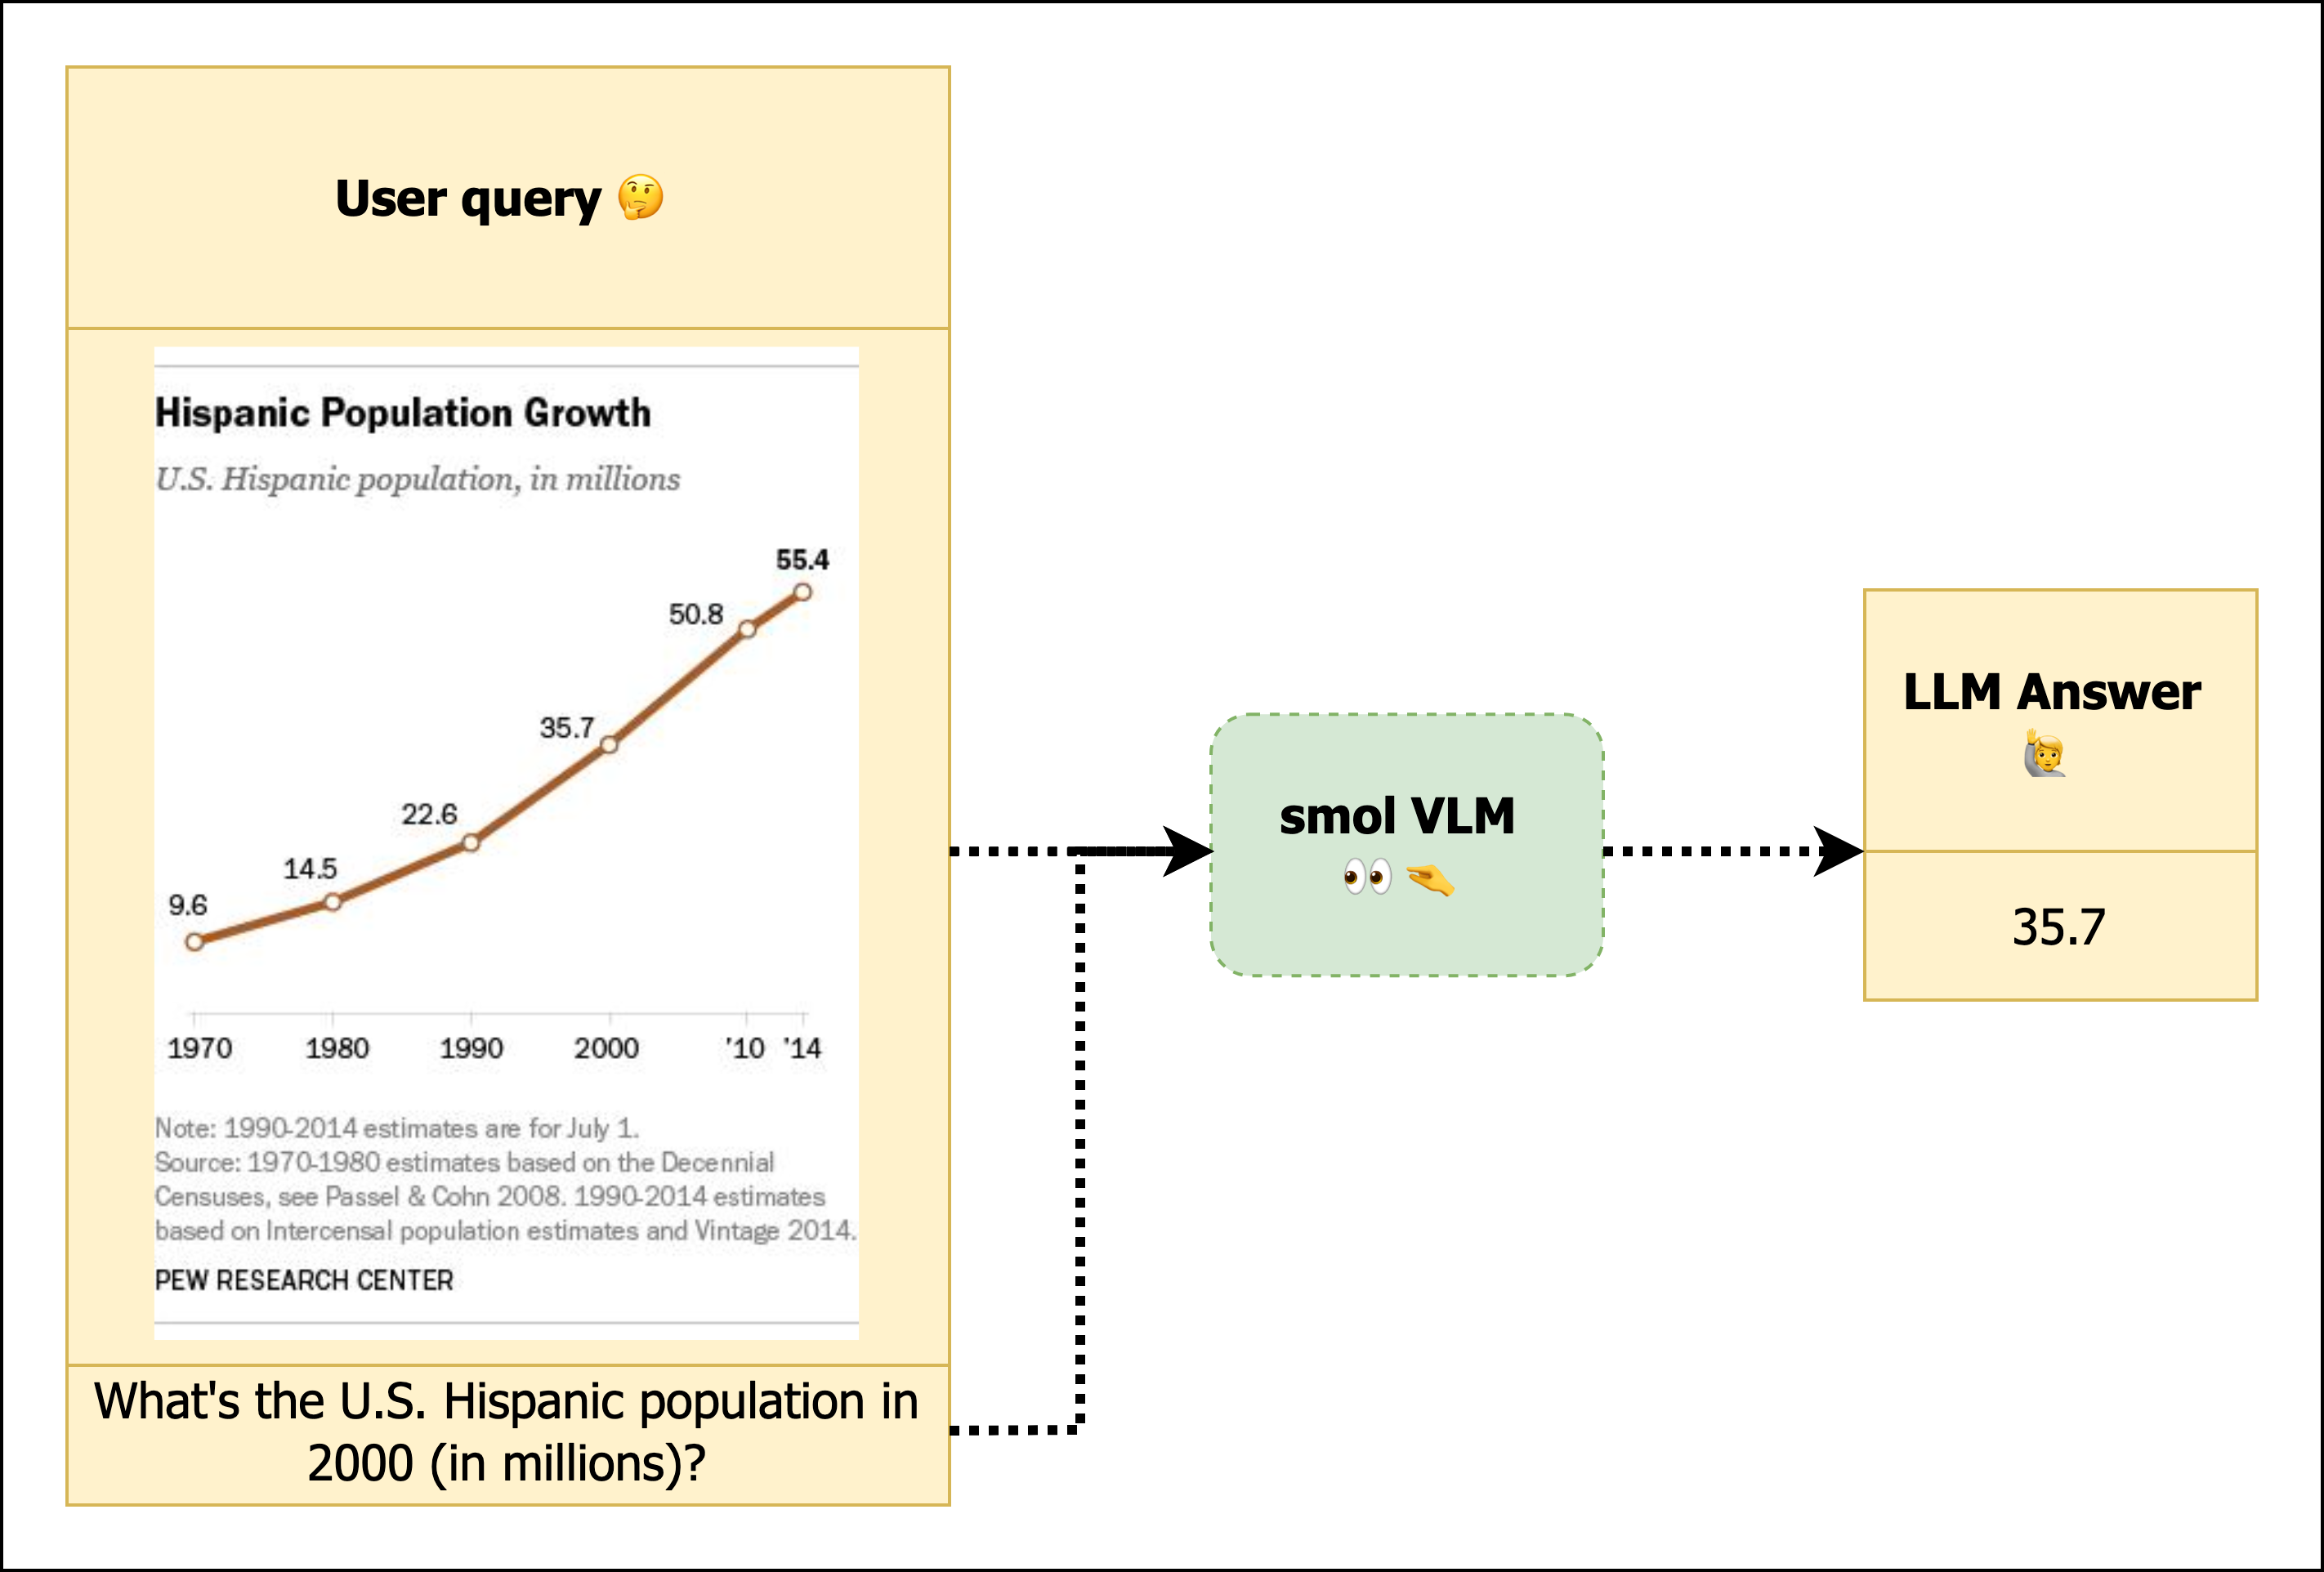

In [8]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


## 3.2 Set Up QLoRA and DPOConfig 🚀

In this step, we’ll configure [QLoRA](https://github.com/artidoro/qlora) for our training setup. **QLoRA** is a powerful fine-tuning technique designed to reduce the memory footprint, making it possible to fine-tune large models efficiently, even on limited hardware.

QLoRA builds upon traditional **LoRA** (Low-Rank Adaptation) by introducing quantization for the adapter weights. This enhancement leads to significantly lower memory usage and faster training, making it an ideal choice for resource-constrained environments.


In [10]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


Next, we will configure the training options using `DPOConfig`.

In [11]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="smolvlm-instruct-trl-dpo-rlaif-v",
    bf16=True,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    num_train_epochs=5,
    dataset_num_proc=8,  # tokenization will use 32 processes
    dataloader_num_workers=8,  # data loading will use 32 workers
    logging_steps=10,
    report_to="tensorboard",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",
)


We’ll use **Direct Preference Optimization (DPO)** to enhance our model’s performance on the specific task. This involves defining the training arguments with the [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index). **DPO** leverages labeled preference data to guide the model toward generating more desirable responses.

As part of the setup, the dataset will be **tokenized** before training and saved to disk. Keep in mind that this process can consume significant disk space, depending on the amount of data used for training. Plan accordingly to avoid running out of storage.

This step may take a while, so feel free to relax and enjoy the process! 😄


In [12]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    tokenizer=processor,
)

Extracting prompt from train dataset (num_proc=8):   0%|          | 0/4738 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=8):   0%|          | 0/4738 [00:00<?, ? examples/s]

Extracting prompt from eval dataset (num_proc=8):   0%|          | 0/42 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=8):   0%|          | 0/42 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=8):   0%|          | 0/4738 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=8):   0%|          | 0/42 [00:00<?, ? examples/s]

Time to Train the Model! 🎉

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations

Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,0.696400,0.689668,0.070737,0.059856,0.454545,0.010881,-527.765686,-551.519592,-0.441455,-0.447946
20,0.694600,0.687929,-0.043065,-0.053715,0.522727,0.010649,-528.903687,-552.655212,-0.478456,-0.485015
30,0.694200,0.689975,-0.061627,-0.068137,0.522727,0.006510,-529.089355,-552.799438,-0.480546,-0.487623
40,0.690600,0.691405,-0.087593,-0.091688,0.568182,0.004095,-529.348999,-553.034973,-0.496209,-0.500481
50,0.686300,0.685563,-0.021663,-0.040609,0.590909,0.018947,-528.689697,-552.524170,-0.476896,-0.482701
60,0.687700,0.687496,-0.065024,-0.082959,0.545455,0.017935,-529.123291,-552.947693,-0.489313,-0.493031
70,0.687600,0.677564,0.026436,-0.010189,0.613636,0.036625,-528.208740,-552.219971,-0.473098,-0.475116
80,0.684500,0.681425,0.053278,0.027829,0.613636,0.025449,-527.940308,-551.839783,-0.460153,-0.468277
90,0.683200,0.684544,0.041992,0.023161,0.613636,0.018831,-528.053162,-551.886475,-0.467933,-0.473805
100,0.682500,0.682565,0.030992,0.005609,0.500000,0.025383,-528.163086,-552.062073,-0.471805,-0.476247


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, wh

KeyboardInterrupt: 

Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)

adapter_model.safetensors:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

# 4. Testing the Fine-Tuned Model 🔍

With our Vision Language Model (VLM) fine-tuned, it’s time to evaluate its performance! In this section, we’ll test the model using examples from the [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted) dataset. Let’s dive into the results and assess how well the model aligns with the preferred responses! 🚀

Before we begin, let’s clean up the GPU memory to ensure smooth and optimal performance. 🧹

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 1.64 GB
GPU reserved memory: 2.01 GB


We will reload the base model using the same pipeline as before.

In [ ]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


We will attach the trained adapter to the pretrained model. This adapter contains the fine-tuning adjustments made during training, enabling the base model to leverage the new knowledge while keeping its core parameters intact. By integrating the adapter, we enhance the model's capabilities without altering its original structure.

In [ ]:
adapter_path = "sergiopaniego/smolvlm-instruct-trl-dpo-rlaif-v"
model.load_adapter(adapter_path)

adapter_config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Let's evaluate the model on an unseen sample.


In [ ]:
test_dataset[20]

{'chosen': [{'content': [{'text': "In the image, there's a dynamic scene at what appears to be a beach or surfing location. The main focus is on a person skillfully riding a wave on a surfboard. This individual is dressed in a yellow shirt and seems to be enjoying the activity. In addition to the surfer, there are other elements in the scene such as waves breaking and creating white foam, indicating the active nature of the water. Nearby, there's another surfboard floating on the surface of the water, suggesting that more people might be participating in surfing or waiting for their turn. The overall atmosphere conveys a sense of fun, adventure, and connection with nature.",
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'In the image, there is a man enthusiastically surfing on a wave in the ocean. He is wearing a yellow shirt and short pants, adding a vibrant color contrast to the scene. The surfer is skillfully balancing himself on his surfboard 

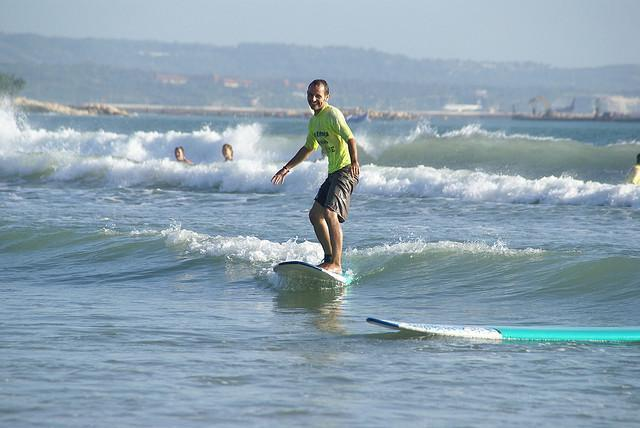

In [ ]:
test_dataset[20]['images'][0]

Let’s create a common function that we can call with different samples to streamline the testing process. This function will allow us to evaluate the model’s performance on multiple examples efficiently without needing to rewrite code for each one. By using this reusable function, we can quickly assess how well the model performs across a variety of inputs.



In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['prompt'],
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample['images'][0]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Now, we’re ready to call the function and evaluate the model! 🚀

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[20])
output

" The image depicts a scene of a person surfing in the ocean. The central figure is a man standing on a surfboard, facing the camera with a joyful expression. He is wearing a bright green rash guard and dark-colored board shorts. The surfboard is white and blue, indicating it is a beginner-friendly board suitable for learning to surf.\n\nSurrounding the man, there are several other individuals in the water. Two people are visible in the background, swimming near the shore. The water is moderately choppy, with small waves breaking on the shore. The waves are white and foamy, indicating they are relatively small and gentle.\n\nIn the background, there is a distant coastline with a few buildings and structures visible. The sky is clear, with a few faint clouds visible. The overall setting appears to be a beach or coastal area, with the ocean and waves as the primary focus.\n\nThe image captures a moment of joy and accomplishment, as the surfer is enjoying the experience of surfing. The ma

The model is now able to generate responses based on the provided image and prompt. For tasks like this, it’s useful to compare your model's performance against a benchmark to see how much it has improved and how it stacks up against other options. For more information and details on this comparison, check out [this post](https://huggingface.co/blog/dpo_vlm#inference).

💻 I’ve developed an example application to test the model, which you can find [here](https://huggingface.co/spaces/sergiopaniego/SmolVLM-trl-sft-ChartQA). You can easily compare it with another Space featuring the pre-trained model, available [here](https://huggingface.co/spaces/HuggingFaceTB/SmolVLM).

In [ ]:
from IPython.display import IFrame

IFrame(src="https://sergiopaniego-smolvlm-trl-dpo-rlaif-v.hf.space", width=1000, height=800)

# 6. Continuing the Learning Journey 🧑‍🎓️

To further enhance your skills with multimodal models, I recommend checking out the resources shared at the beginning of this notebook or revisiting the section with the same name in [Fine-Tuning a Vision Language Model (Qwen2-VL-7B) with the Hugging Face Ecosystem (TRL)](https://huggingface.co/learn/cookbook/fine_tuning_vlm_trl).

These resources will help deepen your knowledge and expertise in multimodal learning.